In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost

Data preprocessing


In [2]:
#load dataset
data = pd.read_csv("pima-diabetes.csv")

In [3]:
data.head(10)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True
5,5,116,74,0,0,25.6,0.201,30,0.0000,False
6,3,78,50,32,88,31.0,0.248,26,1.2608,True
7,10,115,0,0,0,35.3,0.134,29,0.0000,False
8,2,197,70,45,543,30.5,0.158,53,1.7730,True
9,8,125,96,0,0,0.0,0.232,54,0.0000,True


In [4]:
# mapping True diabetes prediction to 1
# mapping False diabetes prediction to 0
diabetes_map= {True:1, False:0}
data['diabetes']=data['diabetes'].map(diabetes_map)
print(data['diabetes'])


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: diabetes, Length: 768, dtype: int64


In [5]:
data.isnull().values.any()  #no null values

False

In [6]:

diabetes_true_count=len(data.loc[data['diabetes']==True])
diabetes_false_count=len(data.loc[data['diabetes']==False])
(diabetes_true_count,diabetes_false_count)

(268, 500)

In [7]:
from sklearn.model_selection import train_test_split,cross_val_score

feature_columns=['num_preg',	'glucose_conc',	'diastolic_bp',	'thickness',	'insulin',	'bmi',	'diab_pred',	'age',	'skin' ]
predicted_class=['diabetes']

In [8]:
X = data[feature_columns].values
y= data[predicted_class].values


X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.30, random_state=10)

In [9]:

print("total number of rows : {0}".format(len(data)))
print("number of rows missing glucose_conc: {0}".format(len(data.loc[data['glucose_conc'] == 0])))
print("number of rows missing glucose_conc: {0}".format(len(data.loc[data['glucose_conc'] == 0])))
print("number of rows missing diastolic_bp: {0}".format(len(data.loc[data['diastolic_bp'] == 0])))
print("number of rows missing insulin: {0}".format(len(data.loc[data['insulin'] == 0])))
print("number of rows missing bmi: {0}".format(len(data.loc[data['bmi'] == 0])))
print("number of rows missing diab_pred: {0}".format(len(data.loc[data['diab_pred'] == 0])))
print("number of rows missing age: {0}".format(len(data.loc[data['age'] == 0])))
print("number of rows missing skin: {0}".format(len(data.loc[data['skin'] == 0])))

total number of rows : 768
number of rows missing glucose_conc: 5
number of rows missing glucose_conc: 5
number of rows missing diastolic_bp: 35
number of rows missing insulin: 374
number of rows missing bmi: 11
number of rows missing diab_pred: 0
number of rows missing age: 0
number of rows missing skin: 227


In [10]:
#this is to deal with the zero values
from sklearn.impute import SimpleImputer
fill_values= SimpleImputer(missing_values=0,strategy="mean")

X_train= fill_values.fit_transform(X_train)
X_test= fill_values.fit_transform(X_test)

In [11]:
classifier=xgboost.XGBClassifier()

In [12]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
classifier.fit(X_train,y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
y_pred=classifier.predict(X_test)

[[111  33]
 [ 35  52]]


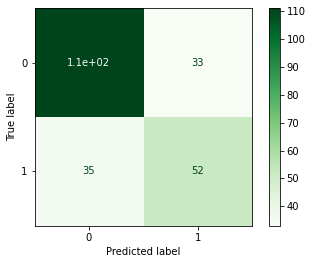

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
cm= confusion_matrix(y_test,y_pred)
score=accuracy_score(y_test,y_pred)
print(cm)
plot_confusion_matrix(classifier, X_test, y_test,cmap='Greens')  
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       144
           1       0.61      0.60      0.60        87

    accuracy                           0.71       231
   macro avg       0.69      0.68      0.69       231
weighted avg       0.70      0.71      0.70       231



In [17]:
score_cross_val=cross_val_score(classifier,X_train,y_train.ravel())
print('Cross validation average score {:.2f}%'.format(score_cross_val.mean()*100))

Cross validation average score 75.04%


In [18]:
try:
  import shap
except:
  !pip install shap 
  import shap



SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions


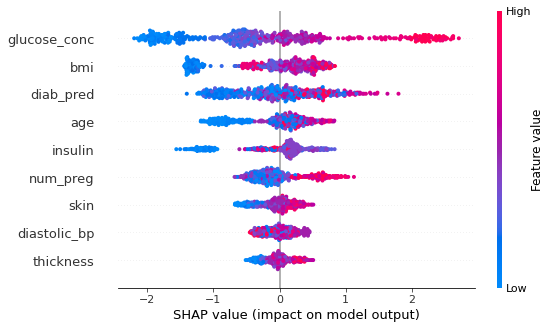

In [19]:
#Create explainer
#Using tree explainer because xgboost is a tree based model
shapexplainer = shap.TreeExplainer(classifier,feature_names=feature_columns)

#Calculating the shap values of the train dataset
shap_values_train = shapexplainer.shap_values(X_train)
#Feature importance graph of train_set
shap.summary_plot(shap_values_train, X_train,feature_names=feature_columns)

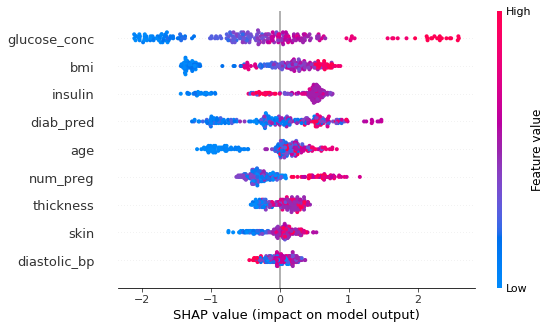

In [20]:
#Calculating the shap values of test tet
shap_values = shapexplainer.shap_values(X_test)
#Feature importance graph of test_set
shap.summary_plot(shap_values, X_test,feature_names=feature_columns)

#The summary plot is an example of global explanations

In [21]:
shap.initjs() # is needed to display the explanation
idx=9
shap.force_plot(shapexplainer.expected_value, shap_values[idx], X_test[idx], feature_names=feature_columns)
#explain a specific instance

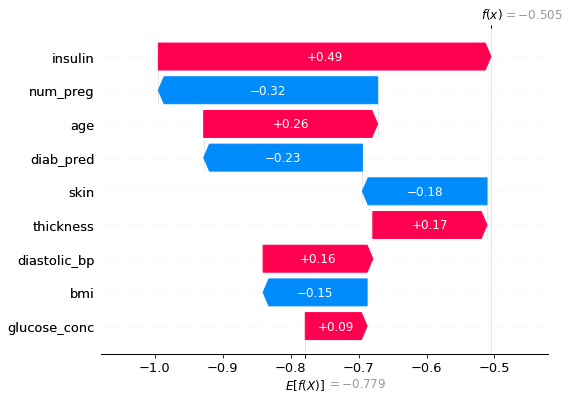

In [22]:
shap.plots._waterfall.waterfall_legacy(shapexplainer.expected_value, shap_values[idx],feature_names=feature_columns)
#explain a specific instance
#Its a different represenation of the force plot